(**Click the icon below to open this notebook in Colab**)

[![Open InColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiangshiyin/machine-learning-for-actuarial-science/blob/main/2025-spring/week06/notebook/demo.ipynb)

# Overview

In our last class, we explored the Titanic dataset, examined it from multiple perspectives, and applied various feature engineering techniques to enhance its explanatory variables. Today, we will continue working with the Titanic dataset, focusing on model training and evaluation techniques to gain deeper insights into predictive modeling.

# Load the dataset

https://www.kaggle.com/competitions/titanic/data
- **The Titanic** https://en.wikipedia.org/wiki/Titanic

| Variable   | Definition                                | Key                                  |
|------------|-------------------------------------------|--------------------------------------|
| survival   | Survival                                 | 0 = No, 1 = Yes                     |
| pclass     | Ticket class                             | 1 = 1st, 2 = 2nd, 3 = 3rd           |
| sex        | Sex                                      |                                      |
| Age        | Age in years                             |                                      |
| sibsp      | # of siblings / spouses aboard the Titanic |                                      |
| parch      | # of parents / children aboard the Titanic |                                      |
| ticket     | Ticket number                            |                                      |
| fare       | Passenger fare                           |                                      |
| cabin      | Cabin number                             |                                      |
| embarked   | Port of Embarkation                     | C = Cherbourg, Q = Queenstown, S = Southampton |

In [1]:
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_csv('../data/titanic/train.csv')
test = pd.read_csv('../data/titanic/test.csv')

# convert all column names to lower cases
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

In [3]:
train.head(3)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# Streamline the data transformations

Here are the data exploration and transformation strategies we used so far:
* Quick survey across key variables
* Detect and address data anomalies
  * Missing values
  * Outliers
* Feature engineering
  * Encode categorical variables
  * Normalize numerical variables
  * Create new features with stronger predictive power

Data exploration process is typically iterative and complex. Once we have a good understanding of the data and some potential strategies to apply in the feature engineering process, we need to make sure these transformation strategies can be easily and consistently applied to new datasets, such as the test set and new batches of data for model retraining. This requires a systematic approach to streamline the data transformations so that we don't need to start from scratch and repeat the same steps for each new dataset. This is especially important in the real-world scenario where we want to productionalize and automate the data transformation process.

In [4]:
train.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

## Missing value imputation

In [5]:
def impute_missing_num_values(df):
    """
    Impute missing values in numerical columns of a DataFrame using the median of each column.

    Args:
    df (pandas.DataFrame): The DataFrame to impute missing values in.

    Returns:
    pandas.DataFrame: The DataFrame with missing values imputed.
    """
    # Select only the numerical columns
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    # Impute missing values with the median of each column
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
    return df


In [6]:
train = impute_missing_num_values(train)
train.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age              0
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

In [7]:
# categorical variables could have missing values too
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html

def impute_missing_cat_values(df, ignore_list):
    """
    Impute missing categorical values with the most frequent value.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        ignore_list (list): List of column names to ignore.    
    Returns:
        pd.DataFrame: DataFrame with imputed missing categorical values.
    """
    for col in df.columns:
        if col not in ignore_list:
            if df[col].dtype == 'object':
                df[col] = df[col].fillna(df[col].mode()[0])
    return df

In [8]:
train = impute_missing_cat_values(train, ignore_list=['cabin'])
train.isnull().sum()

passengerid      0
survived         0
pclass           0
name             0
sex              0
age              0
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         0
dtype: int64

⚠️ **Attention:** We will treat the missing values in `cabin` in the feature engineering step!!


## Feature Engineering
- Encode categorical features
- Normalize numerical features
- Create new features

In [9]:
# The categorical variables in the datasets

cat_cols = [
    col
    for col in train.columns if train[col].dtype == "object"
] 
print(cat_cols)

['name', 'sex', 'ticket', 'cabin', 'embarked']


In [10]:
# apply onehot encoding to the categorical columns
# use the sklearn library

from sklearn.preprocessing import OneHotEncoder

def onehot_encode(df, ignore_list):
    cat_cols = [
        col for col in df.columns if col not in ignore_list and df[col].dtype == 'object'
    ]
    encoder = OneHotEncoder()
    encoded = encoder.fit_transform(df[cat_cols])
    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(cat_cols))
    df = pd.concat([df, encoded_df], axis=1)
    df = df.drop(cat_cols, axis=1)
    return df

In [11]:
train = onehot_encode(train, ignore_list=['cabin', 'name', 'ticket'])

In [12]:
# transform numeric features, log transform `fare`
import numpy as np

def log_transform(df, features, drop=False):
    for feature in features:
        df[feature+'_log'] = np.log1p(df[feature]) 
    if drop:
        df = df.drop(features, axis=1)
    return df

In [13]:
train = log_transform(train, features=['fare'])
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'sex_female', 'sex_male', 'embarked_C',
       'embarked_Q', 'embarked_S', 'fare_log'],
      dtype='object')

In [14]:
# Create new features
import re

def create_features(df):
    df['has_cabin'] = df['cabin'].apply(lambda x: 0 if type(x) == float else 1)
    df['family_size'] = df['sibsp'] + df['parch'] + 1
    df['is_alone'] = df['family_size'].apply(lambda x: 1 if x == 1 else 0)
    df['title'] = df['name'].apply(lambda x: re.search('([A-Z][a-z]+)\\.', x).group(1))
    df['cabin'] = df['cabin'].fillna('U0')
    df['deck'] = df['cabin'].apply(lambda x: re.search('([A-Z]+)', x).group(1))
    df['name_len_cat'] = df['name'].apply(lambda x: 0 if len(x) <= 23 else 1 if len(x) <= 28 else 2 if len(x) <= 40 else 3)
    df['age_cat'] = df['age'].apply(lambda x: 0 if x <= 14 else 1 if x <= 30 else 2 if x <= 40 else 3 if x <= 50 else 4 if x <= 60 else 5)
    df['fare_log_cat'] = df['fare_log'].apply(lambda x: 0 if x <= 2.7 else 1 if x <= 3.2 else 2 if x <= 3.6 else 3)
    return df

In [15]:
train = create_features(train)
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'sex_female', 'sex_male', 'embarked_C',
       'embarked_Q', 'embarked_S', 'fare_log', 'has_cabin', 'family_size',
       'is_alone', 'title', 'deck', 'name_len_cat', 'age_cat', 'fare_log_cat'],
      dtype='object')

## Put all together

In [16]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

def impute_missing_num_values(df):
    """
    Impute missing values in numerical columns of a DataFrame using the median of each column.

    Args:
    df (pandas.DataFrame): The DataFrame to impute missing values in.

    Returns:
    pandas.DataFrame: The DataFrame with missing values imputed.
    """
    # Select only the numerical columns
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    # Impute missing values with the median of each column
    for col in num_cols:
        df[col] = df[col].fillna(df[col].median())
    return df

def impute_missing_cat_values(df, ignore_list):
    """
    Impute missing categorical values with the most frequent value.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        ignore_list (list): List of column names to ignore.    
    Returns:
        pd.DataFrame: DataFrame with imputed missing categorical values.
    """
    for col in df.columns:
        if col not in ignore_list:
            if df[col].dtype == 'object':
                df[col] = df[col].fillna(df[col].mode()[0])
    return df

def log_transform(df, features, drop=False):
    for feature in features:
        df[feature+'_log'] = np.log1p(df[feature]) 
    if drop:
        df = df.drop(features, axis=1)
    return df

def create_features(df):
    df['has_cabin'] = df['cabin'].apply(lambda x: 0 if type(x) == float else 1)
    df['family_size'] = df['sibsp'] + df['parch'] + 1
    df['is_alone'] = df['family_size'].apply(lambda x: 1 if x == 1 else 0)
    df['title'] = df['name'].apply(lambda x: re.search('([A-Z][a-z]+)\\.', x).group(1))
    df['cabin'] = df['cabin'].fillna('U0')
    df['deck'] = df['cabin'].apply(lambda x: re.search('([A-Z]+)', x).group(1))
    df['name_len_cat'] = df['name'].apply(lambda x: 0 if len(x) <= 23 else 1 if len(x) <= 28 else 2 if len(x) <= 40 else 3)
    df['age_cat'] = df['age'].apply(lambda x: 0 if x <= 14 else 1 if x <= 30 else 2 if x <= 40 else 3 if x <= 50 else 4 if x <= 60 else 5)
    df['fare_log_cat'] = df['fare_log'].apply(lambda x: 0 if x <= 2.7 else 1 if x <= 3.2 else 2 if x <= 3.6 else 3)
    return df

def load_data():
    train = pd.read_csv('../data/titanic/train.csv')
    test = pd.read_csv('../data/titanic/test.csv')
    # convert all column names to lower cases
    train.columns = train.columns.str.lower()
    test.columns = test.columns.str.lower()    
    return train, test

def transform_data(df, encoder=None):
    df = impute_missing_num_values(df)
    df = impute_missing_cat_values(df, ['cabin', 'embarked'])
    df = log_transform(df, ['fare'])
    df = create_features(df)
    
    cat_attributes = ['sex', 'embarked', 'title', 'deck']
    if not encoder:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoder.fit(df[cat_attributes])
    encoded = encoder.transform(df[cat_attributes])
    df = pd.concat([df, pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_attributes))], axis=1)
    # drop columns that are not needed
    df = df.drop([
        'name', 'ticket', 'cabin', 'fare'
        # , 'age', 'fare', 'sibsp', 'parch'
    ] + cat_attributes, axis=1)
    return df, encoder

train, test = load_data()
train, encoder = transform_data(train)
test, _ = transform_data(test, encoder)

In [17]:
train.head(2)

,passengerid,survived,pclass,age,sibsp,parch,fare_log,has_cabin,family_size,is_alone,name_len_cat,age_cat,fare_log_cat,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,embarked_nan,title_Capt,title_Col,title_Countess,title_Don,title_Dr,title_Jonkheer,title_Lady,title_Major,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,deck_U
0,1,0,3,22.0,1,0,2.110213,0,2,0,0,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,1,1,38.0,1,0,4.280593,1,2,0,3,2,3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
test.shape

(418, 44)

In [19]:
test.head(3)

,passengerid,pclass,age,sibsp,parch,fare_log,has_cabin,family_size,is_alone,name_len_cat,age_cat,fare_log_cat,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,embarked_nan,title_Capt,title_Col,title_Countess,title_Don,title_Dr,title_Jonkheer,title_Lady,title_Major,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,deck_U
0,892,3,34.5,0,0,2.178064,0,1,1,0,2,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,893,3,47.0,1,0,2.079442,0,2,0,2,3,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,894,2,62.0,0,0,2.369075,0,1,1,1,5,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Train a simple model

In [20]:
# train a simple logistic regression model to predict the survival label
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(
    train.drop(columns=['survived', 'passengerid']), # everything except the survival label
    train['survived'] # the survival label
)

pred = lr.predict(test.drop(columns=['passengerid']))

/Users/xiangshiyin/Documents/Teaching/machine-learning-for-actuarial-science/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
df_submission = pd.concat([test['passengerid'], pd.DataFrame(pred, columns=['survived'])], axis=1)
df_submission.head(3)

,passengerid,survived
0,892,0
1,893,1
2,894,0


In [22]:
df_submission.to_csv('../data/titanic/submission.csv', index=False)

## Evaluate the prediction results

https://www.kaggle.com/competitions/titanic/overview/evaluation
![](https://almablog-media.s3.ap-south-1.amazonaws.com/image_14_4f4fc2cf7d.png)

## AutoML exploration

In [23]:
X_train = train.drop(columns=['survived', 'passengerid'])
y_train = train['survived']

In [24]:
X_train.head(2)

,pclass,age,sibsp,parch,fare_log,has_cabin,family_size,is_alone,name_len_cat,age_cat,fare_log_cat,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,embarked_nan,title_Capt,title_Col,title_Countess,title_Don,title_Dr,title_Jonkheer,title_Lady,title_Major,title_Master,title_Miss,title_Mlle,title_Mme,title_Mr,title_Mrs,title_Ms,title_Rev,title_Sir,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,deck_U
0,3,22.0,1,0,2.110213,0,2,0,0,1,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,38.0,1,0,4.280593,1,2,0,3,2,3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**FLAML** - https://github.com/microsoft/FLAML/tree/main
- `pip install flaml[automl]`
- [Documentation](https://microsoft.github.io/FLAML/docs/Getting-Started)
- Best practices [[link](https://learn.microsoft.com/en-us/fabric/data-science/automated-machine-learning-fabric#automl-workflow)]

In [45]:
from flaml import AutoML

automl = AutoML()
settings = {
    "time_budget": 60,  # total running time in seconds
    "metric": 'accuracy', 
                        # check the documentation for options of metrics (https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#optimization-metric)
    "task": 'classification',  # task type
    "log_file_name": 'airlines_experiment.log',  # flaml log file
    "seed": 7654321,    # random seed
    "ensemble": True,
}
automl.fit(X_train, y_train, **settings)

[flaml.automl.logger: 02-16 15:45:14] {1728} INFO - task = classification


[flaml.automl.logger: 02-16 15:45:14] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 02-16 15:45:14] {1838} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 02-16 15:45:14] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 02-16 15:45:15] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 02-16 15:45:15] {2393} INFO - Estimated sufficient time budget=1398s. Estimated necessary time budget=32s.
[flaml.automl.logger: 02-16 15:45:15] {2442} INFO -  at 0.3s,	estimator lgbm's best error=0.2189,	best estimator lgbm's best error=0.2189
[flaml.automl.logger: 02-16 15:45:15] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 02-16 15:45:15] {2442} INFO -  at 0.3s,	estimator lgbm's best error=0.2189,	best estimator lgbm's best error=0.2189
[flaml.automl.logger: 02-16 15:45:15] {2258} INFO - iteration 2, current learner lgbm
[flaml.automl.l

/Users/xiangshiyin/Documents/Teaching/machine-learning-for-actuarial-science/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [46]:
X_test = test.drop(columns=['passengerid'])
y_test_pred = automl.predict(X_test)
df_submission = pd.concat([test['passengerid'], pd.DataFrame(y_test_pred, columns=['survived'])], axis=1)
df_submission.head(3)


,passengerid,survived
0,892,0
1,893,0
2,894,0


In [47]:
df_submission.to_csv('../data/titanic/submission.csv', index=False)

In [48]:
automl.best_estimator

'lgbm'

In [49]:
automl.best_config

{'n_estimators': 16,
 'num_leaves': 19,
 'min_child_samples': 7,
 'learning_rate': np.float64(0.41587884609282355),
 'log_max_bin': 10,
 'colsample_bytree': np.float64(0.8334793666447552),
 'reg_alpha': np.float64(1.329638867774165),
 'reg_lambda': np.float64(0.26166563816625876)}

In [50]:
automl.model.estimator.feature_importances_

AttributeError: 'StackingClassifier' object has no attribute 'estimator'

In [51]:
# Get feature importance values
importances = automl.model.estimator.feature_importances_
# Get feature names from the dataset
feature_names = X_train.columns
# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# Sort by importance (highest first)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

AttributeError: 'StackingClassifier' object has no attribute 'estimator'

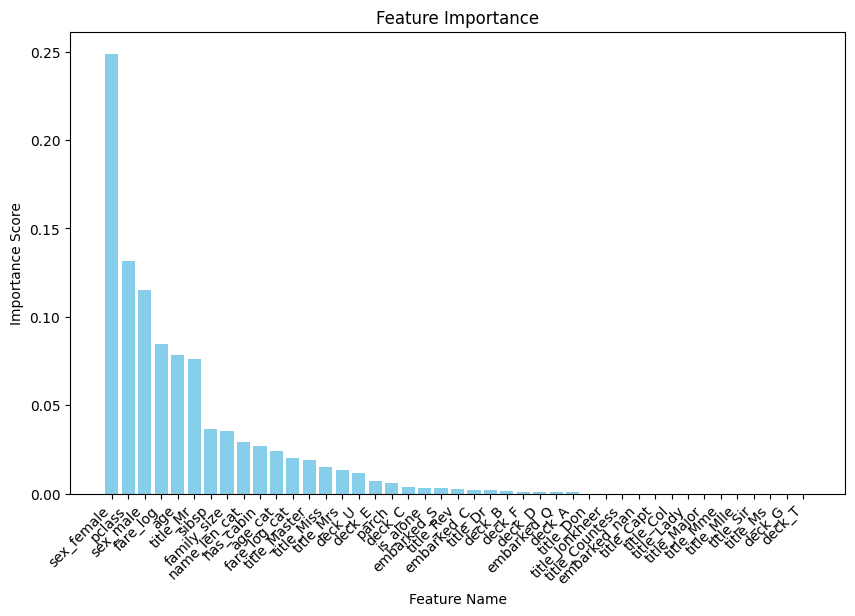

In [52]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')

# Rotate feature names for readability
plt.xticks(rotation=45, ha='right')  # Tilt labels 45 degrees and align to the right

# Labels and title
plt.xlabel('Feature Name')
plt.ylabel('Importance Score')
plt.title('Feature Importance')

plt.show()